<class 'pandas.core.series.Series'>


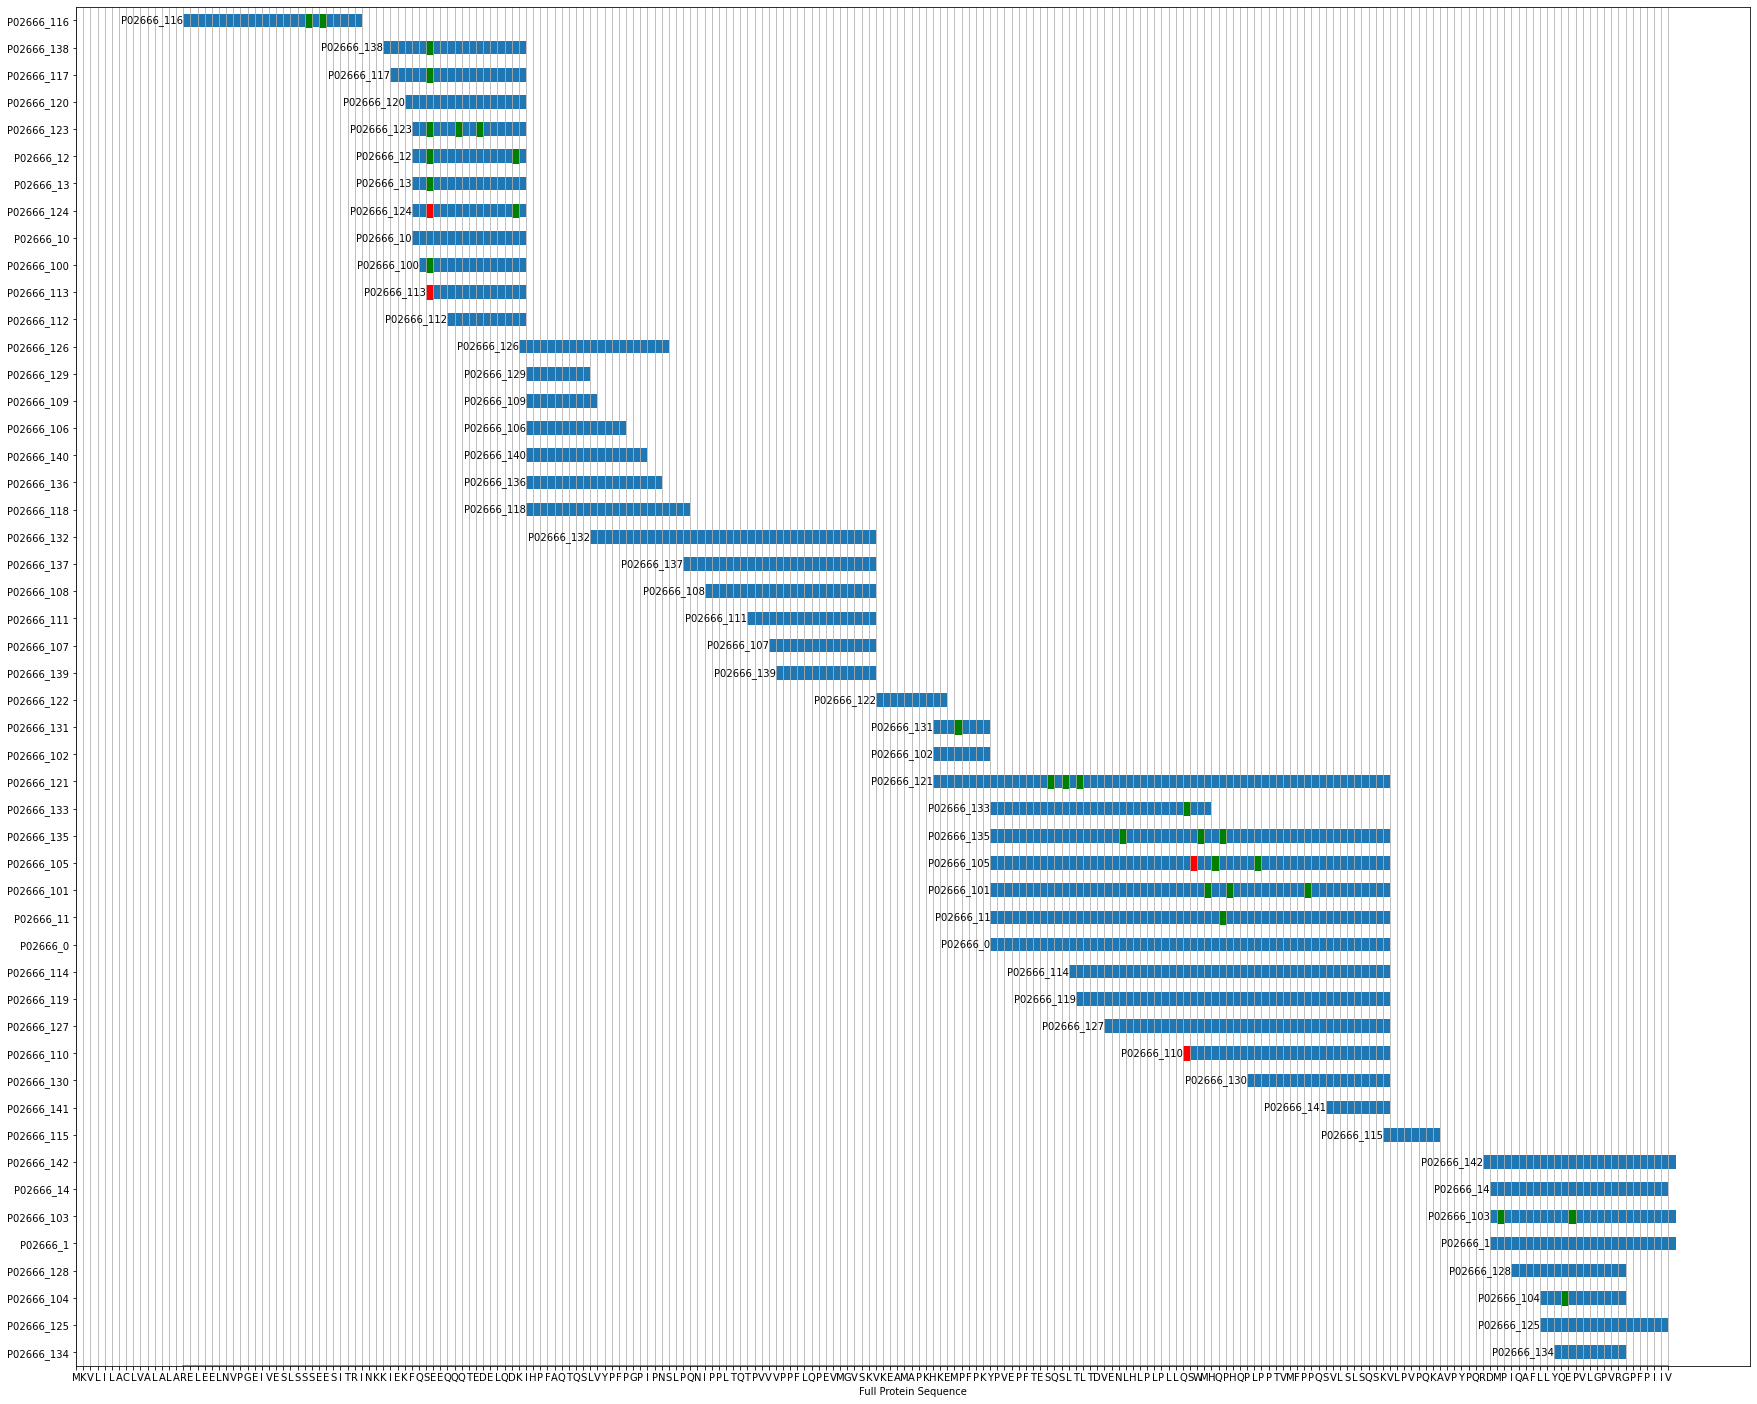

In [6]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from utils import get_protein_sequence
import re
import pandas as pd

path = r"UHT milk P036.csv"
 
df = pd.read_csv(path)

# indicies have sign in front
def get_position_of_mass_shift_and_sign(input_string):
    # get charachters after and before mass shift
    ls = input_string.split('(')
    if len(ls) == 0:
        return np.nan
    #replace everythting witthin parenthesis with "#"
    modified_string = re.sub(r"\([^()]*\)", "#", input_string)
    modified_string = modified_string[2:-2] #remove first and last splice sites
    #get indices of "#"
    indices = [m.start()-1 for m in re.finditer("#", modified_string)]
    # add sign value in front of every index determined by value in ls 
    counter = 0
    for idx in indices:
        if input_string[idx+4] == '-' : #4 is 2 removed indices and + for the "(" and the sign
            indices[counter] = -indices[counter]
        counter += 1
    return indices 


# get position of mass shift in "peptide" for each row
df["Position of Mass Shift"] = df["Peptide"].apply(get_position_of_mass_shift_and_sign)
#df["mass_shift_pos"] = df.apply(get_position_of_mass_shift)
def plot_rect(data, delta=0.5):
    """data is a dictionary, {"Label":(low,hi), ... }
    return a drawing that you can manipulate, show, save etc"""
    print(type(data))
    yspan = len(data)
    yplaces = [.5+i for i in range(yspan)]
    #sort map by values, lowest first

    ylabels = sorted(data.keys(), key=lambda x: data[x][0], reverse=True)

    fig = plt.figure(figsize=(30,25))
    ax = fig.add_subplot(111)
    ax.set_yticks(yplaces)
    ax.set_yticklabels(ylabels)
    ax.set_ylim((0,yspan))

    # later we'll need the min and max in the union of intervals
    low, hi, _, ms_pos=  data[ylabels[0]][0]
    for pos, label in zip(yplaces,ylabels):
        start, end, peptide, ms_pos = data[label][0]
        start, end = start-1, end-1
        ax.add_patch(patches.Rectangle((start,pos-delta/2.0),end-start+1,delta))
        ax.text(start, pos, label, ha='right', va='center')
        for _ms in ms_pos:
            if _ms > 0:
                ax.add_patch(patches.Rectangle((start+_ms,pos-delta/2.0),1,delta, color="green"))
            else:
                _ms = (-1)*_ms
                ax.add_patch(patches.Rectangle((start+_ms,pos-delta/2.0),1,delta, color="red"))
        #annotate the rectangle with label inside
        if start<low : low=start
        if end>hi : hi=end

    # little small trick, draw an invisible line so that the x axis
    # limits are automatically adjusted...
    ax.plot((low,hi),(0,0))
    ax.grid(axis='x')
    # eventually return what we have done
    return ax

# get position of mass shift in "peptide" for each row
df["Position of Mass Shift"] = df["Peptide"].apply(get_position_of_mass_shift_and_sign)
# this is the main script, note that we have imported pyplot as plt
start_end_df = df[["Start", "End", "Protein Accession", "Peptide", 'Position of Mass Shift', 'PTM']]
#only look at values for protein : P02666
start_end_df = start_end_df[start_end_df["Protein Accession"] == "P02666"]
start_end_df.sort_values('Start', inplace=True)
start_end_df['index1'] = start_end_df.index
#concat index1 and protein accession
start_end_df['Protein_Accession_idx'] = start_end_df['Protein Accession'] +"_" + start_end_df['index1'].astype(str) 
start_end_df["(start,end,peptide,pos_ms)"] = start_end_df[["Start", "End", "Peptide",'Position of Mass Shift']].apply(tuple, axis=1)
start_end_df.drop(["Start", "End", "index1"], axis=1, inplace=True)
start_end_df.sort_values('Protein_Accession_idx', inplace=True)
new = start_end_df.head(50)
# make dictionary with index as keys and (Start,End) as values
data = new.groupby("Protein_Accession_idx").apply(lambda x: x["(start,end,peptide,pos_ms)"].tolist())

# call the function and give its result a name
ax1 = plot_rect(data)
# so that we can further manipulate it using the `axes` methods, e.g.
seqq = get_protein_sequence("P02666")
ax1.set_xlabel("Full Protein Sequence")
ax1.set_xticks(range(0,len(seqq)))
# create list of chars from string 
seqq_list = list(seqq)
ax1.set_xticklabels(seqq_list)
#rotate x-axis labels
# finally save or show what we have
plt.show()

In [7]:
import math

normalized_dfs = normalize_intensities_by_protein_intensity(df)
first = normalized_dfs[0]

def colors_from_values(values, palette_name):
    indices = np.round(values * (len(values) - 1)).astype(np.int32)
    # use the indices to get the colors
    palette = sns.color_palette(palette_name, len(values))
    return np.array(palette).take(indices, axis=0)

def plot_overlap_barchart_by_intensity_and_sample(df, selected_protein= "P02666"):
    df_new = df[df["Protein Accession"] == selected_protein]
    seq_list = list(get_protein_sequence(selected_protein))
    _len = len(seq_list)
    overlaps_list_1 = [0]*_len
    overlaps_list_2 = [0]*_len
    overlaps_list_3 = [0]*_len
    overlaps_list_4 = [0]*_len

    # add intensity into all positions where there is an overlap
    for i in range(len(df_new)):
        row = df_new.iloc[i]
        for j in range(row['Start'], row['End']):
            if not pd.isnull(row["Area Sample 1"]):
                overlaps_list_1[j] += row['Area Sample 1']
            if not pd.isnull(row["Area Sample 2"]):
                overlaps_list_2[j] += row['Area Sample 2']
            if not pd.isnull(row["Area Sample 3"]):
                overlaps_list_3[j] += row['Area Sample 3']            
            if not pd.isnull(row["Area Sample 4"]):
                overlaps_list_4[j] += row['Area Sample 4']

    overlaps_list_2 = np.add(overlaps_list_1, overlaps_list_2)
    overlaps_list_3 = np.add(overlaps_list_2, overlaps_list_3)
    overlaps_list_4 = np.add(overlaps_list_3, overlaps_list_4)

    df_overlaps1 = pd.DataFrame(list(zip(range(_len), overlaps_list_1)), columns=['Position', 'Overlaps'])
    df_overlaps2 = pd.DataFrame(list(zip(range(_len), overlaps_list_2)), columns=['Position', 'Overlaps'])
    df_overlaps3 = pd.DataFrame(list(zip(range(_len), overlaps_list_3)), columns=['Position', 'Overlaps'])
    df_overlaps4 = pd.DataFrame(list(zip(range(_len), overlaps_list_4)), columns=['Position', 'Overlaps'])

    plt.figure(figsize=(30,10))

    bar4 = sns.barplot(x="Position", y= "Overlaps", data= df_overlaps4, color='salmon')
    bar3 = sns.barplot(x="Position", y= "Overlaps", data= df_overlaps3, color='green')
    bar2 = sns.barplot(x="Position", y= "Overlaps", data= df_overlaps2, color='blue')
    bar1 = sns.barplot(x="Position", y= "Overlaps", data= df_overlaps1, color='red')


    bar1.set_xticklabels(seq_list)
    bar1.set_title(f"Number of overlaps per position - for protein: {selected_protein}")
    plt.show()    

plot_overlap_barchart_by_intensity_and_sample(first)

NameError: name 'normalize_intensities_by_protein_intensity' is not defined

In [12]:
from collections import Counter
from utils import normalize_intensities_by_protein_intensity, get_protein_sequence
import re
import numpy as np
import seaborn as sns
import pandas as pd
from collections import Counter
import plotly.express as px
import math

def df_to_plotly(df):
    return {'count': df.values.tolist(),
            'position': df.columns.tolist(),
            'modification': df.index.tolist()}

small_df = start_end_df.head(50)
x = range(len(seqq_list))
ll = small_df['PTM'].to_list()

# add column with mass shift position + value in "start" column
positionAndModifications = {}
positions = []
for i in range(len(ll)):
    if pd.isnull(ll[i]) or ll[i] == "":
        continue
    mods = ll[i].split(";")
    position = small_df['(start,end,peptide,pos_ms)'].iloc[i][0]
    if (position not in positions):
        positions.append(position)
    for mod in mods:
        if position not in positionAndModifications:
            positionAndModifications[position] = {}
            positionAndModifications[position][mod.strip()] = 1
        else:
            key = positionAndModifications[position]
            if mod.strip() not in key:
                positionAndModifications[position][mod.strip()] = 1
            else:
                positionAndModifications[position][mod.strip()] += 1

dataFrames = []
for key, val in positionAndModifications.items():
    newDataFrame = pd.DataFrame(positionAndModifications)
    print(key)
    print(val)
newDataFrame

49
{'Phosphorylation (STY)': 1}
129
{'Dioxidation (M)': 2, 'Deamidation (NQ)': 5, 'Oxidation (M)': 2, 'lal': 2}
199
{'Oxidation (M)': 1, 'Deamidation (NQ)': 1}
206
{'Deamidation (NQ)': 1}
156
{'Pyro-glu from Q': 1}
50
{'Phosphorylation (STY)': 1}
16
{'Phosphorylation (STY)': 1}
45
{'Phosphorylation (STY)': 1}
48
{'Phosphorylation (STY)': 3, 'Deamidation (NQ)': 3, 'lal': 1}
121
{'Phosphorylation (STY)': 1, 'Deamidation (NQ)': 1, 'lal': 1, 'Oxidation (M)': 1}
44
{'Phosphorylation (STY)': 1}


,49,129,199,206,156,50,16,45,48,121,44
Phosphorylation (STY),1.0,NaN,NaN,NaN,NaN,1.0,1.0,1.0,3.0,1.0,1.0
Dioxidation (M),NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Deamidation (NQ),NaN,5.0,1.0,1.0,NaN,NaN,NaN,NaN,3.0,1.0,NaN
Oxidation (M),NaN,2.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN
lal,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,NaN
Pyro-glu from Q,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN
